# 问答生成器 - 验证
## 引入

In [1]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from utils.write import collapse_documents, test_data, glove, expand_answers, look_up_token, START_TOKEN, END_TOKEN

## 环境参数

In [2]:
# run params
SECTION = 'write'
RUN_ID = '0002'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

mode = 'build'  # 'load'

## 读取数据

In [3]:
#### LOAD DATA ####
test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)

## 参数及模型

In [4]:
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

#### TRAINING MODEL ####
document_tokens = tf.keras.Input(shape=(MAX_DOC_SIZE,), name='document_tokens')

embedding = tf.keras.layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIMENS,
    weights=[glove],
    mask_zero=True,
    name='embedding'
)
document_emb = embedding(document_tokens)

answer_outputs = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(GRU_UNITS, return_sequences=True),
    name='answer_outputs'
)(document_emb)
answer_tags = tf.keras.layers.Dense(
    2, activation='softmax',
    name='answer_tags'
)(answer_outputs)

encoder_input_mask = tf.keras.Input(
    shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE),
    name='encoder_input_mask'
)
encoder_inputs = tf.keras.layers.Lambda(
    lambda x: tf.matmul(x[0], x[1]),
    name="encoder_inputs"
)([encoder_input_mask, answer_outputs])
encoder_cell = tf.keras.layers.GRU(
    2 * GRU_UNITS, name='encoder_cell'
)(encoder_inputs)

decoder_inputs = tf.keras.Input(shape=(MAX_Q_SIZE,), name='decoder_inputs')
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = tf.keras.layers.GRU(
    2 * GRU_UNITS,
    return_sequences=True,
    name='decoder_cell'
)
decoder_states = decoder_cell(decoder_emb, initial_state=[encoder_cell])

decoder_projection = tf.keras.layers.Dense(
    VOCAB_SIZE, name='decoder_projection',
    activation='softmax', use_bias=False
)
decoder_outputs = decoder_projection(decoder_states)

total_model = tf.keras.Model([document_tokens, decoder_inputs, encoder_input_mask],
                          [answer_tags, decoder_outputs])

#### INFERENCE MODEL ####
answer_model = tf.keras.Model(document_tokens, [answer_tags])
decoder_initial_state_model = tf.keras.Model([document_tokens, encoder_input_mask], [encoder_cell])

decoder_inputs_dynamic = tf.keras.Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = tf.keras.Input(
    shape=(2 * GRU_UNITS,),
    name='decoder_init_state_dynamic'
)  # the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, 
                                      initial_state=[decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = tf.keras.Model([decoder_inputs_dynamic, decoder_init_state_dynamic],
                             [decoder_outputs_dynamic, decoder_states_dynamic])


## 加载模型参数

In [5]:
### LOAD MODEL WEIGHTS ####
model_num = 1000

total_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
question_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
answer_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
decoder_initial_state_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)

## 答案预测

<Figure size 1080x360 with 0 Axes>

Predicted answer probabilities


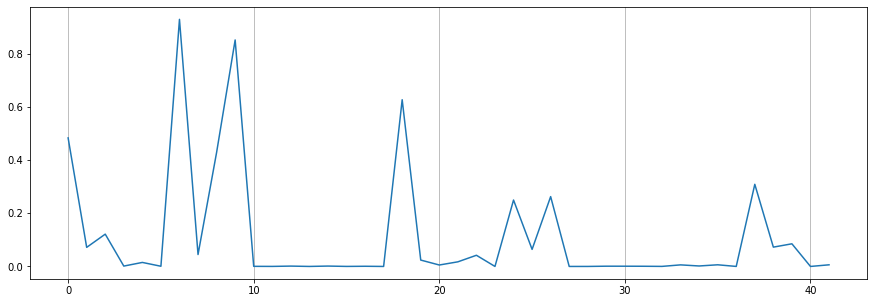

0 the 0.48
1 winning 0.07
2 goal 0.12
3 was 0.0
4 scored 0.02
5 by 0.0
6 23-year-old 0.93
7 striker 0.04
8 joe 0.43
9 bloggs 0.85
10 during 0.0
11 the 0.0
12 match 0.0
13 between 0.0
14 arsenal 0.0
15 and 0.0
16 barcelona 0.0
17 . 0.0
18 arsenal 0.63
19 recently 0.02
20 signed 0.01
21 the 0.02
22 striker 0.04
23 for 0.0
24 50 0.25
25 million 0.06
26 pounds 0.26
27 . 0.0
28 the 0.0
29 next 0.0
30 match 0.0
31 is 0.0
32 in 0.0
33 two 0.01
34 weeks 0.0
35 time, 0.01
36 on 0.0
37 july 0.31
38 31st 0.07
39 2005 0.09
40 . 0.0
41  0.01


In [6]:
# answer placement predictions
plt.figure(figsize=(15, 5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('Predicted answer probabilities')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i],
          np.round(answer_preds[idx][i][1], 2))

## 问题预测

In [7]:
def generate_question(start_answer, end_answer):
    print(f'Chosen answer range {start_answer} : {end_answer}')
    print(batch['document_words'][idx][start_answer:(1+end_answer)])
    answer_preds = answer_model.predict(batch["document_tokens"])

    answers = [[0] * len(answer_preds[idx])]
    for i in range(start_answer, end_answer + 1):
        answers[0][i] = 1

    answer_batch = expand_answers(batch, answers)

    next_decoder_init_state = decoder_initial_state_model.predict(
        [answer_batch['document_tokens'][[idx]],
            answer_batch['answer_masks'][[idx]]]
    )

    word_tokens = np.array([START_TOKEN])
    questions = [look_up_token(START_TOKEN)]

    ended = False
    counter = 0

    while not ended:
        counter += 1

        word_preds, next_decoder_init_state = question_model.predict(
            [word_tokens, next_decoder_init_state]
        )

        next_decoder_init_state = np.squeeze(next_decoder_init_state, axis=1)
        word_tokens = np.argmax(word_preds, 2)[0]

        questions.append(look_up_token(word_tokens[0]))

        if word_tokens[0] == END_TOKEN or counter > 20:
            ended = True

    questions = ' '.join(questions)
    print('\nPredicted Question:')
    print(questions)

In [8]:
generate_question(6, 9)

Chosen answer range 6 : 9
['23-year-old', 'striker', 'joe', 'bloggs']

Predicted Question:
<START> who fell on final climb in final <UNK> as a <UNK> in the <UNK> ? <END>


In [9]:
generate_question(14, 16)

Chosen answer range 14 : 16
['arsenal', 'and', 'barcelona']

Predicted Question:
<START> where the atp tournament ? <END>


In [10]:
generate_question(24, 26)

Chosen answer range 24 : 26
['50', 'million', 'pounds']

Predicted Question:
<START> record winner christie <END>


In [11]:
generate_question(37, 39)

Chosen answer range 37 : 39
['july', '31st', '2005']

Predicted Question:
<START> when is the contest with the start time <END>
